In [1]:
import numpy as np

import cv2
import sys
import torch

# from effdet import create_model_from_config
from hydra.utils import instantiate
from omegaconf import OmegaConf
from PIL import Image
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [2]:
sys.path.append('../src')

In [3]:
from train import create_dataset
from data.loader import fast_collate
from data.sampler import CustomSampler
from models.efficient_det import create_model_from_config
from utils.visualize import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

In [4]:
def draw_bboxes(image, bboxes, color, box_format='coco', yxyx=False):
    if yxyx:
        # yxyx -> xyxy
        bboxes = bboxes[:, [1,0,3,2]]
    
    for box in bboxes:
        pt1 = tuple(box[:2])
        if box_format == 'coco':
            pt2 = tuple(box[:2] + box[2:])
        elif box_format == 'pascal_voc':
            pt2 = tuple(box[2:])
        else:
            raise AttributeError("Lel, kek, no {} for you :p".format(box_format))
            
        cv2.rectangle(image, pt1, pt2, color, 1)

In [5]:
conf = OmegaConf.load('../config/train.yaml')
base_conf = OmegaConf.load('../config/model/effdet/base.yaml')
effdet_d3_conf = OmegaConf.load('../config/model/effdet/tf_d2.yaml')
conf = OmegaConf.merge(base_conf, effdet_d3_conf, conf)

In [6]:
ds = create_dataset(conf.data.train, show_progress=True)

Loading train data...


Parsing bboxes...: 100%|██████████| 2793/2793 [00:18<00:00, 154.60it/s]

train: 53067 images


In [7]:
# dl = torch.utils.data.DataLoader(ds, batch_size=6, shuffle=False, collate_fn=fast_collate)

In [8]:
sampler = CustomSampler(ds)
dl = torch.utils.data.DataLoader(ds, sampler=sampler, batch_size=6, collate_fn=fast_collate)

In [9]:
conf.model.params.config

{'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'act_type': 'swish', 'separable_conv': True, 'apply_bn_for_resampling': True, 'conv_after_downsample': False, 'conv_bn_relu_pattern': False, 'use_native_resize_op': False, 'pooling_type': None, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'delta': 0.1, 'box_loss_weight': 50.0, 'name': 'tf_efficientdet_d2', 'backbone_name': 'tf_efficientnet_b2', 'backbone_args': {'drop_path_rate': 0.2}, 'image_size': 768, 'fpn_channels': 112, 'fpn_cell_repeats': 5, 'box_class_repeats': 3, 'pad_type': 'same', 'redundant_bias': True, 'url': 'https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d2-cb4ce77d.pth', 'num_classes': 90, 'pretrained_backbone': False}

In [10]:
model = create_model_from_config(
    conf.model.params.config, 
    bench_name='train', 
)

In [11]:
device = torch.device('cuda:1')
model = model.to(device)

In [12]:
state_dict = torch.load('/home/dmitry/Downloads/checkpoint_19950.pth')
# state_dict = torch.load('/media/dmitry/data/weights/wheat/003/checkpoint_14896.pth')
model.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [13]:
model.eval()
_ = model.requires_grad_(False)

In [14]:
mean = torch.tensor(list(conf.data.mean)).to(device).view(1, 3, 1, 1).mul_(255)
std = torch.tensor(list(conf.data.std)).to(device).view(1, 3, 1, 1).mul_(255)

In [15]:
data_iter = iter(dl)

In [16]:
images, targets = next(data_iter)
targets.keys()

dict_keys(['bbox', 'cls', 'img_scale', 'img_size'])

In [17]:
images_gpu = images.to(device).float().sub_(mean).div_(std)
targets_gpu = {k: v.to(device) for k, v in targets.items()}

In [18]:
out = model(images_gpu, targets_gpu)
predictions = out["detections"]

In [19]:
model.model.class_net.predict

SeparableConv2d(
  (conv_dw): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=112, bias=False)
  (conv_pw): Conv2d(112, 9, kernel_size=(1, 1), stride=(1, 1))
)

torch.Size([41, 4])


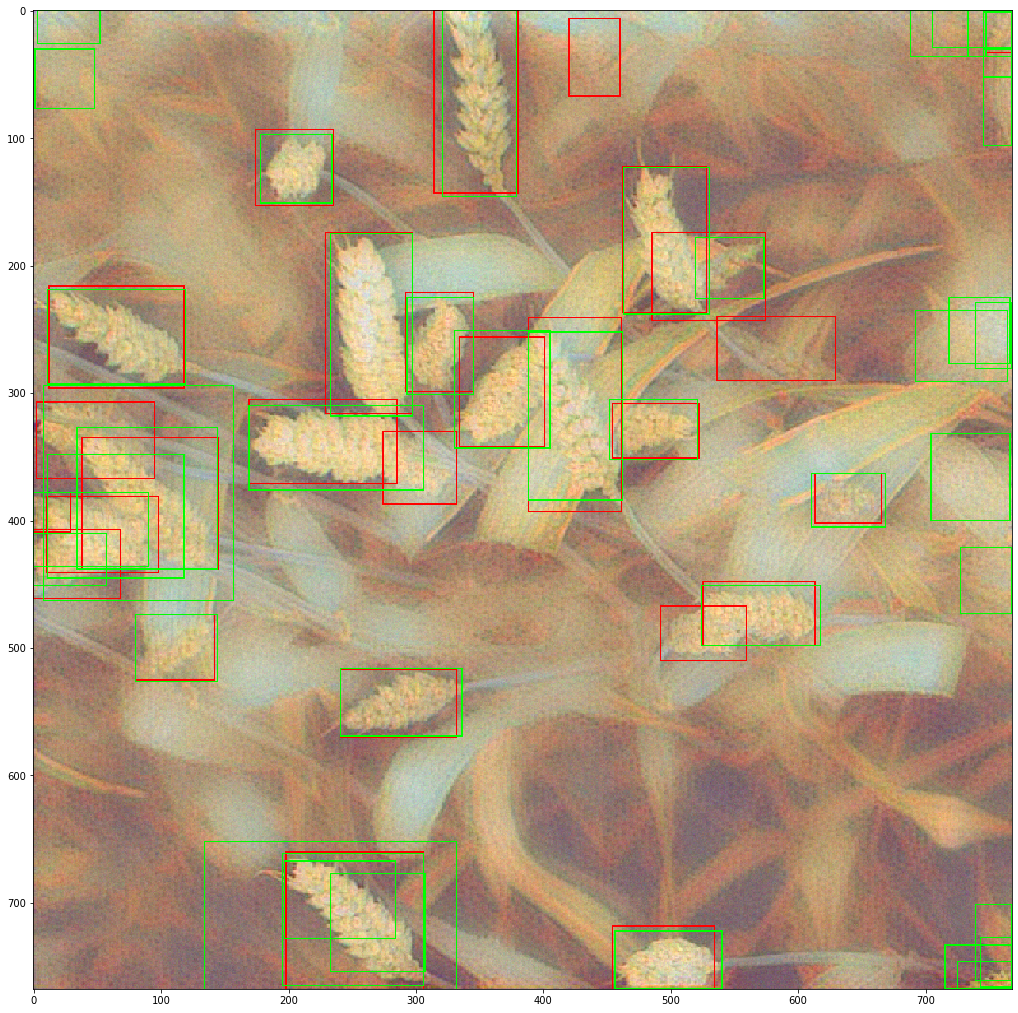

In [20]:
i = 0
score_thresh = 0.05

preds = predictions[i, :, :]
preds = preds[preds[:, 4] >= score_thresh, :4]
print(preds.shape)

preds = preds / targets_gpu['img_scale'][i]
preds = preds.cpu().numpy()

image = images_gpu[i] * std[0] + mean[0]
image = image.permute(1, 2, 0).cpu().numpy().astype(np.uint8)

target_yxyx = conf.data.train.params.box_format == 'yxyx'
draw_bboxes(image, targets['bbox'][i], (255, 0, 0), box_format='pascal_voc', yxyx=target_yxyx)
draw_bboxes(image, preds, (0, 255, 0), box_format='coco')

plt.figure(figsize=(18, 18))
plt.imshow(image)